# The code is based on my paper here: https://doi.org/10.1016/j.compag.2020.105326
or https://sci-hub.tw/https://doi.org/10.1016/j.compag.2020.105326
# The original dataset and paper from here: https://github.com/Horea94/Fruit-Images-Dataset
# 120 fruit types can be downloaded here: https://www.kaggle.com/moltean/fruits/version/2

In [1]:
import os
import re
import PIL
import sys
import json
import time
import timm
import math
import copy
import torch
import pickle
import geffnet
import logging
import fnmatch
import argparse
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from geffnet import create_model
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
from efficientnet_pytorch import EfficientNet
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix,accuracy_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
data_dir = '/Users/mac/Downloads/Fruit/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'

# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Using the image datasets and the trainforms, define the data_loader
# batch_size = 64 for EfficientNet from B0 - B3
# batch_size = 32 for EfficientNet B4, B5
# batch_size = 16 for EfficientNet_B6
# batch_size = 8 for EfficientNet_B7
# batch_size = 32 for MixNet_s
batch_size = 64
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4, pin_memory = True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(device)
"""
# Label mapping
with open('/home/linh/Downloads/Fruit/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
"""

f = open('/Users/mac/Downloads/Fruit/labels.txt','r')
cat_to_name = f.read()
print(cat_to_name)
f.close()

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['train'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}

    
# Run this to test the data loader
images, labels = next(iter(data_loader['val']))
images.size()

{'train': 61488, 'val': 20622}
cpu
{\rtf1\ansi\ansicpg1252\cocoartf2512
\cocoatextscaling0\cocoaplatform0{\fonttbl\f0\fmodern\fcharset0 Courier;}
{\colortbl;\red255\green255\blue255;\red0\green0\blue0;}
{\*\expandedcolortbl;;\cssrgb\c0\c0\c0;}
\paperw11900\paperh16840\margl1440\margr1440\vieww10800\viewh8400\viewkind0
\deftab720
\pard\pardeftab720\partightenfactor0

\f0\fs26 \cf0 \expnd0\expndtw0\kerning0
Apple Braeburn\
Apple Crimson Snow\
Apple Golden 1\
Apple Golden 2\
Apple Golden 3\
Apple Granny Smith\
Apple Pink Lady\
Apple Red 1\
Apple Red 2\
Apple Red 3\
Apple Red Delicious\
Apple Red Yellow 1\
Apple Red Yellow 2\
Apricot\
Avocado\
Avocado ripe\
Banana\
Banana Lady Finger\
Banana Red\
Beetroot\
Blueberry\
Cactus fruit\
Cantaloupe 1\
Cantaloupe 2\
Carambula\
Cauliflower\
Cherry 1\
Cherry 2\
Cherry Rainier\
Cherry Wax Black\
Cherry Wax Red\
Cherry Wax Yellow\
Chestnut\
Clementine\
Cocos\
Dates\
Eggplant\
Ginger Root\
Granadilla\
Grape Blue\
Grape Pink\
Grape White\
Grape White 2\

torch.Size([64, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


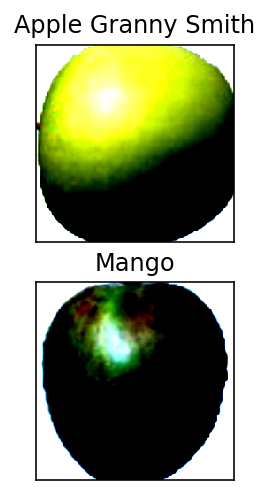

In [13]:
def showimage(data_loader, number_images, cat_to_name):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(number_images, 4))
    # display 20 images
    for idx in np.arange(number_images):
        ax = fig.add_subplot(2, number_images/2, idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx])
        plt.imshow(img)
        ax.set_title(cat_to_name[labels.tolist()[idx]])
        

#### to show some  images
showimage(data_loader['val'],2,cat_to_name)

In [14]:
#model = EfficientNet.from_pretrained('efficientnet-b3')
#model = timm.create_model('tf_efficientnet_b6', pretrained = True)
#from efficientnet_pytorch import EfficientNet
#model = EfficientNet.from_pretrained('efficientnet-b6')
model = create_model('efficientnet_b0', pretrained=True)
# Create classifier
for param in model.parameters():
    param.requires_grad = True
#num_in_features = 1536 
n_classes = 120
model.classifier = nn.Linear(model.classifier.in_features, n_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}
list(model.class_to_idx.items())


[('Apple Braeburn', 0),
 ('Apple Crimson Snow', 1),
 ('Apple Golden 1', 2),
 ('Apple Golden 2', 3),
 ('Apple Golden 3', 4),
 ('Apple Granny Smith', 5),
 ('Apple Pink Lady', 6),
 ('Apple Red 1', 7),
 ('Apple Red 2', 8),
 ('Apple Red 3', 9),
 ('Apple Red Delicious', 10),
 ('Apple Red Yellow 1', 11),
 ('Apple Red Yellow 2', 12),
 ('Apricot', 13),
 ('Avocado', 14),
 ('Avocado ripe', 15),
 ('Banana', 16),
 ('Banana Lady Finger', 17),
 ('Banana Red', 18),
 ('Beetroot', 19),
 ('Blueberry', 20),
 ('Cactus fruit', 21),
 ('Cantaloupe 1', 22),
 ('Cantaloupe 2', 23),
 ('Carambula', 24),
 ('Cauliflower', 25),
 ('Cherry 1', 26),
 ('Cherry 2', 27),
 ('Cherry Rainier', 28),
 ('Cherry Wax Black', 29),
 ('Cherry Wax Red', 30),
 ('Cherry Wax Yellow', 31),
 ('Chestnut', 32),
 ('Clementine', 33),
 ('Cocos', 34),
 ('Dates', 35),
 ('Eggplant', 36),
 ('Ginger Root', 37),
 ('Granadilla', 38),
 ('Grape Blue', 39),
 ('Grape Pink', 40),
 ('Grape White', 41),
 ('Grape White 2', 42),
 ('Grape White 3', 43),
 ('Grap

In [16]:
list(model.idx_to_class.items())

[(0, 'Apple Braeburn'),
 (1, 'Apple Crimson Snow'),
 (2, 'Apple Golden 1'),
 (3, 'Apple Golden 2'),
 (4, 'Apple Golden 3'),
 (5, 'Apple Granny Smith'),
 (6, 'Apple Pink Lady'),
 (7, 'Apple Red 1'),
 (8, 'Apple Red 2'),
 (9, 'Apple Red 3'),
 (10, 'Apple Red Delicious'),
 (11, 'Apple Red Yellow 1'),
 (12, 'Apple Red Yellow 2'),
 (13, 'Apricot'),
 (14, 'Avocado'),
 (15, 'Avocado ripe'),
 (16, 'Banana'),
 (17, 'Banana Lady Finger'),
 (18, 'Banana Red'),
 (19, 'Beetroot'),
 (20, 'Blueberry'),
 (21, 'Cactus fruit'),
 (22, 'Cantaloupe 1'),
 (23, 'Cantaloupe 2'),
 (24, 'Carambula'),
 (25, 'Cauliflower'),
 (26, 'Cherry 1'),
 (27, 'Cherry 2'),
 (28, 'Cherry Rainier'),
 (29, 'Cherry Wax Black'),
 (30, 'Cherry Wax Red'),
 (31, 'Cherry Wax Yellow'),
 (32, 'Chestnut'),
 (33, 'Clementine'),
 (34, 'Cocos'),
 (35, 'Dates'),
 (36, 'Eggplant'),
 (37, 'Ginger Root'),
 (38, 'Granadilla'),
 (39, 'Grape Blue'),
 (40, 'Grape Pink'),
 (41, 'Grape White'),
 (42, 'Grape White 2'),
 (43, 'Grape White 3'),
 (44, '

In [5]:
model.to(device)

def train_model(model, criterion, optimizer, scheduler, num_epochs=200, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 1000 == 999:
                    print('[%d, %d] loss: %.8f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':                
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':                
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_loss,
                            'best_val_accuracy': best_acc,
                            'scheduler_state_dict' : scheduler.state_dict(),
                            }, 
                            CHECK_POINT_PATH
                            )
                print(f'New record loss is SAVED: {epoch_loss}')
            """if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                iteration_change_loss = 0

            if iteration_change_loss == 10: #choose a number of epochs for patience
                print('Early stopping after {0} iterations without the decrease of the val loss'. format(iteration_change_loss))
                break"""
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.8f} Best val loss: {:.8f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [ ]:
CHECK_POINT_PATH = '/home/linh/Downloads/Fruit/EfficientNet_B0_SGD.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
if checkpoint == None:
    CHECK_POINT_PATH = CHECK_POINT_PATH
model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs = 100,
                                                 checkpoint = None#torch.load(CHECK_POINT_PATH)
                                                 ) 
                                                
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict': scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint not found
Epoch 0/99
----------
train Loss: 2.51690385 Acc: 0.56835480
val Loss: 0.52496326 Acc: 0.93836679
New best model found!
New record loss: 0.5249632575292035, previous record loss: inf
New record loss is SAVED: 0.5249632575292035

Epoch 1/99
----------
train Loss: 0.39575551 Acc: 0.92398517
val Loss: 0.15160335 Acc: 0.97740277
New best model found!
New record loss: 0.1516033526249508, previous record loss: 0.5249632575292035
New record loss is SAVED: 0.1516033526249508

Epoch 2/99
----------
train Loss: 0.19433551 Acc: 0.95862607
val Loss: 0.08355084 Acc: 0.98894385
New best model found!
New record loss: 0.08355083656179814, previous record loss: 0.1516033526249508
New record loss is SAVED: 0.08355083656179814

Epoch 3/99
----------
train Loss: 0.13331760 Acc: 0.96975020
val Loss: 0.05431901 Acc: 0.99233828
New best model found!
New record loss: 0.05431901327575598, previous record loss: 0.08355083656179814
New record loss is SAVED: 0.05431901327575598

Epoch 4/99
--

In [ ]:
"""CHECK_POINT_PATH = '/content/drive/My Drive/fruits/checkpoint_Fruits_MixNet_S_pretrained_weight.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
  model.load_state_dict(checkpoint['model_state_dict'])
  best_model_wts = copy.deepcopy(model.state_dict())
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  #scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  best_loss = checkpoint['best_val_loss']
  best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)  

since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['val']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/content/drive/My Drive/fruits/Results_Fruits_MixNet_S_pretrained_weight.csv',index=False)

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

sns.heatmap(confusion_matrix(y_test, y_pred))
accuracy_score(y_test, y_pred)"""